# Introduction

In this project, you will build a neural network of your own design to evaluate the Fashion MNIST dataset.

## Imports

In [8]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

## Load the Dataset

Specify your transforms as a list if you intend to.
The transforms module is already loaded as `transforms`.

FashionMNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [9]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Create training set and define training dataloader
trainset = datasets.FashionMNIST('~/Deeplearning with pytorch udacity/FMNIST_Data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


# Create test set and define test dataloader
testset = datasets.FashionMNIST('~/Deeplearning with pytorch udacity/FMNIST_Data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)



100%|██████████| 26421880/26421880 [00:01<00:00, 17050390.02it/s]


Extracting /root/Deeplearning with pytorch udacity/FMNIST_Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Deeplearning with pytorch udacity/FMNIST_Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 266809.67it/s]


Extracting /root/Deeplearning with pytorch udacity/FMNIST_Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Deeplearning with pytorch udacity/FMNIST_Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5041282.65it/s]


Extracting /root/Deeplearning with pytorch udacity/FMNIST_Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Deeplearning with pytorch udacity/FMNIST_Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1322488.94it/s]


Extracting /root/Deeplearning with pytorch udacity/FMNIST_Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Deeplearning with pytorch udacity/FMNIST_Data/FashionMNIST/raw



In [10]:
#size of training dataset
print(len(trainloader.dataset))
print(len(trainloader))
#Do you know what is the difference?

60000
938


Check shapes of Inputs and Outputs

In [11]:
dataiter = iter(trainloader) #queue containing the batches
images, labels = dataiter.next() #fetches the next batch in the queue
print(type(images))
print(images.shape)
print(labels.shape)
print(labels)


AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [12]:
# Create training set and define training dataloader
trainset,validset=torch.utils.data.random_split(trainset,[50000,10000])

trainloader_new = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)



## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [13]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


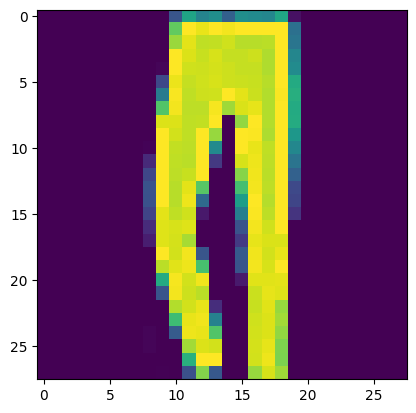

0


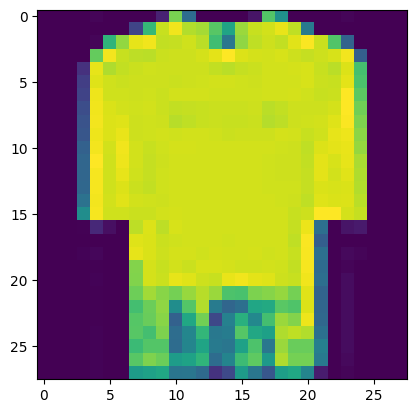

6


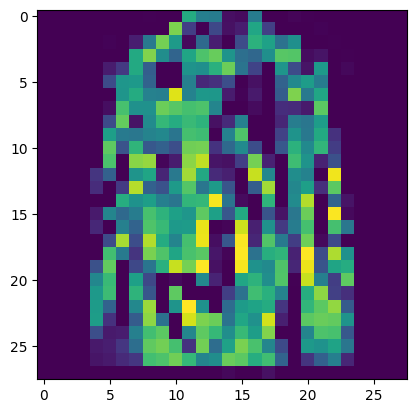

4


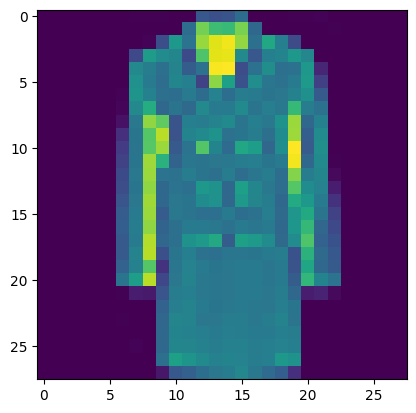

3


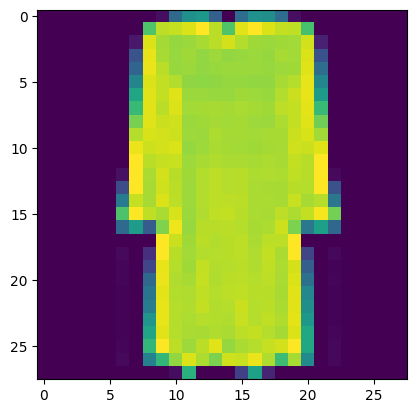

In [14]:
# Explore data
## YOUR CODE HERE ##
show5(trainloader_new)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [15]:
## YOUR CODE HERE ##
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Define dropout layers with a dropout probability (e.g., 0.2)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after the second layer
        x = F.relu(self.fc3(x))
        x = self.dropout(x)  # Apply dropout after the rhird layer
        x=self.fc4(x) #output shape ((64,10)) #No dropout added
        #print(x.shape)
        x = F.log_softmax(x, dim=1) #logsoftmax for each row
        #print(x.shape) #output shape ((64,10))
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
## Create Model Instance, Evaluation Criteria, and define the optimizer
model = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [18]:

#Training Loop
epochs = 10
TLL=[]
VLL=[]
valid_loss=0;running_loss=0;
for e in range(epochs):
    running_loss = 0
    valid_loss = 0
    model.train()
    for images, labels in trainloader_new:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    for images, labels in validloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels) #summing
        valid_loss += loss.item()
    else:
        T=running_loss/len(trainloader_new) #Error/batch
        V=valid_loss/len(validloader)    #Error/batch
        print(f"Epoch: {e}", f"    Training loss: {T}",f"    Validation loss: {V}")
        TLL.append(T)
        VLL.append(V)


Epoch: 0     Training loss: 0.6357788132394061     Validation loss: 0.44943516820099705
Epoch: 1     Training loss: 0.4626687673275428     Validation loss: 0.3636782023177785
Epoch: 2     Training loss: 0.4311486755490608     Validation loss: 0.36772542223808874
Epoch: 3     Training loss: 0.4124930407042089     Validation loss: 0.3782591016808893
Epoch: 4     Training loss: 0.39745976922609616     Validation loss: 0.35575568210926783
Epoch: 5     Training loss: 0.38813872463867793     Validation loss: 0.3354089720423814
Epoch: 6     Training loss: 0.38060692920709205     Validation loss: 0.3334752726516906
Epoch: 7     Training loss: 0.3703305544260213     Validation loss: 0.32912787396437043
Epoch: 8     Training loss: 0.3690150435585195     Validation loss: 0.3611334258109141
Epoch: 9     Training loss: 0.36141746218704507     Validation loss: 0.3446006922490278


What is the model that is going to be saved and used for testing?

How can we save the model with best loss

In [8]:
print(len(testloader))

157


In [19]:
#Evaluate Model Accuracy using the test dataset
Test_loss = 0

model.eval()
for images, labels in testloader:
  log_ps = model(images)
  loss = criterion(log_ps, labels) #summing
  Test_loss += loss.item()

print(Test_loss/len(testloader)) #NLLLoss / Batch


0.38915939619586726


How to calculate the accuracy?

Number of correct classified images / Total Number of images

In [20]:
#Evaluate Model Accuracy using the test dataset
correct_per_batch = 0

model.eval()
for images, labels in testloader:
  log_ps = model(images)
  ps = torch.exp(log_ps)
  Pred_indices = torch.argmax(ps,dim=1)
  #print("Bach predictions",Pred_indices)
  #print("Real predictions",labels)
  correct_per_batch += (Pred_indices == labels).sum().item()

#Accuracy
correctly_classified = ( correct_per_batch/len(testloader.dataset) )* 100
print(correctly_classified)

86.31


In the training loop, How can we save the best model ?


In [23]:

#Training Loop
best_val_loss = float("inf")

epochs = 10
TLL=[]
VLL=[]
valid_loss=0;running_loss=0;
for e in range(epochs):
    running_loss = 0
    valid_loss = 0
    model.train()
    for images, labels in trainloader_new:

        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    for images, labels in validloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels) #summing
        valid_loss += loss.item()

    T=running_loss/len(trainloader_new) #Error/batch
    V=valid_loss/len(validloader)    #Error/batch
    print(f"Epoch: {e}", f"    Training loss: {T}",f"    Validation loss: {V}")
    TLL.append(T)
    VLL.append(V)
    if V <  best_val_loss:
      best_val_loss = V
      Model_state_dict = model.state_dict()

#Save the best Model of the previously trained 10 Models
torch.save(Model_state_dict, 'best_model.pth')
print(f"New best model saved with NLLLoss Of {best_val_loss}")

Epoch: 0     Training loss: 0.6270581051669157     Validation loss: 0.42588780497669415
Epoch: 1     Training loss: 0.46891311420808973     Validation loss: 0.4072675286394775
Epoch: 2     Training loss: 0.43510533219484415     Validation loss: 0.36342930129379225
Epoch: 3     Training loss: 0.4112774802805365     Validation loss: 0.3572064763896025
Epoch: 4     Training loss: 0.39822057499300184     Validation loss: 0.3612723459673535
Epoch: 5     Training loss: 0.38737624671186327     Validation loss: 0.35421524268047067
Epoch: 6     Training loss: 0.38010943501882843     Validation loss: 0.35135338991690596
Epoch: 7     Training loss: 0.3740381503958836     Validation loss: 0.35257292856836014
Epoch: 8     Training loss: 0.36693923101019676     Validation loss: 0.34391457772558665
Epoch: 9     Training loss: 0.360927735743544     Validation loss: 0.329111711519539
New best model saved with NLLLoss Of 0.329111711519539


Now we can load the best Model to test it against the test dataset using?


In [24]:

#Load the presaved Best Model
model = Classifier()

model.load_state_dict(torch.load('best_model.pth'))

#Evaluate Model Accuracy using the test dataset
correct_per_batch = 0

model.eval()
for images, labels in testloader:
  log_ps = model(images)
  ps = torch.exp(log_ps)
  Pred_indices = torch.argmax(ps,dim=1)
  #print("Bach predictions",Pred_indices)
  #print("Real predictions",labels)
  correct_per_batch += (Pred_indices == labels).sum().item()

#Accuracy
correctly_classified = ( correct_per_batch/len(testloader.dataset) )* 100
print(correctly_classified)


87.05000000000001


**Step-by-Step Implementation**

1.   Load the dataset.
2.   Apply different normalization techniques.
3.   Visualize the original and normalized data
distributions using histograms.

In [25]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import fetch_california_housing
import pandas as pd

In [26]:
# Step 1: Load the dataset
california_housing = fetch_california_housing()
data = california_housing.data
data_tensor = torch.tensor(data, dtype=torch.float32)

# Create a DataFrame
df = pd.DataFrame(data, columns=california_housing.feature_names)

# Add target column
df['Target'] = california_housing.target

# Display the first few rows of the DataFrame
print(df.head())


   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  


In [3]:
skewness = df.skew()
skewness

MedInc         1.646657
HouseAge       0.060331
AveRooms      20.697869
AveBedrms     31.316956
Population     4.935858
AveOccup      97.639561
Latitude       0.465953
Longitude     -0.297801
Target         0.977763
dtype: float64

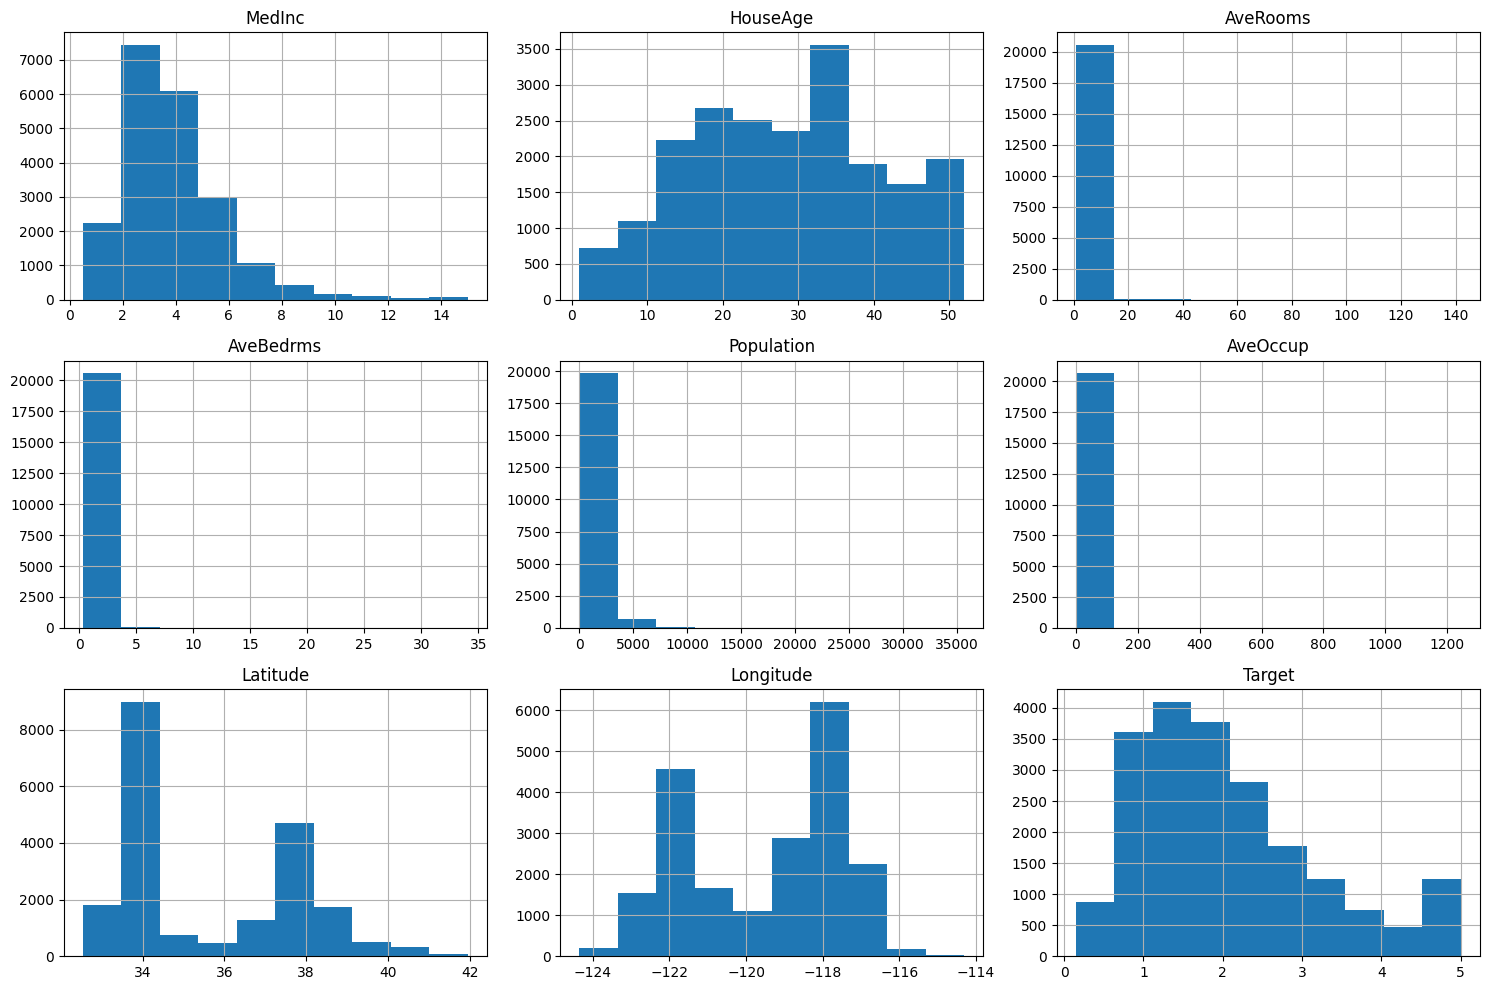

In [4]:
# Plot histograms for all features
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

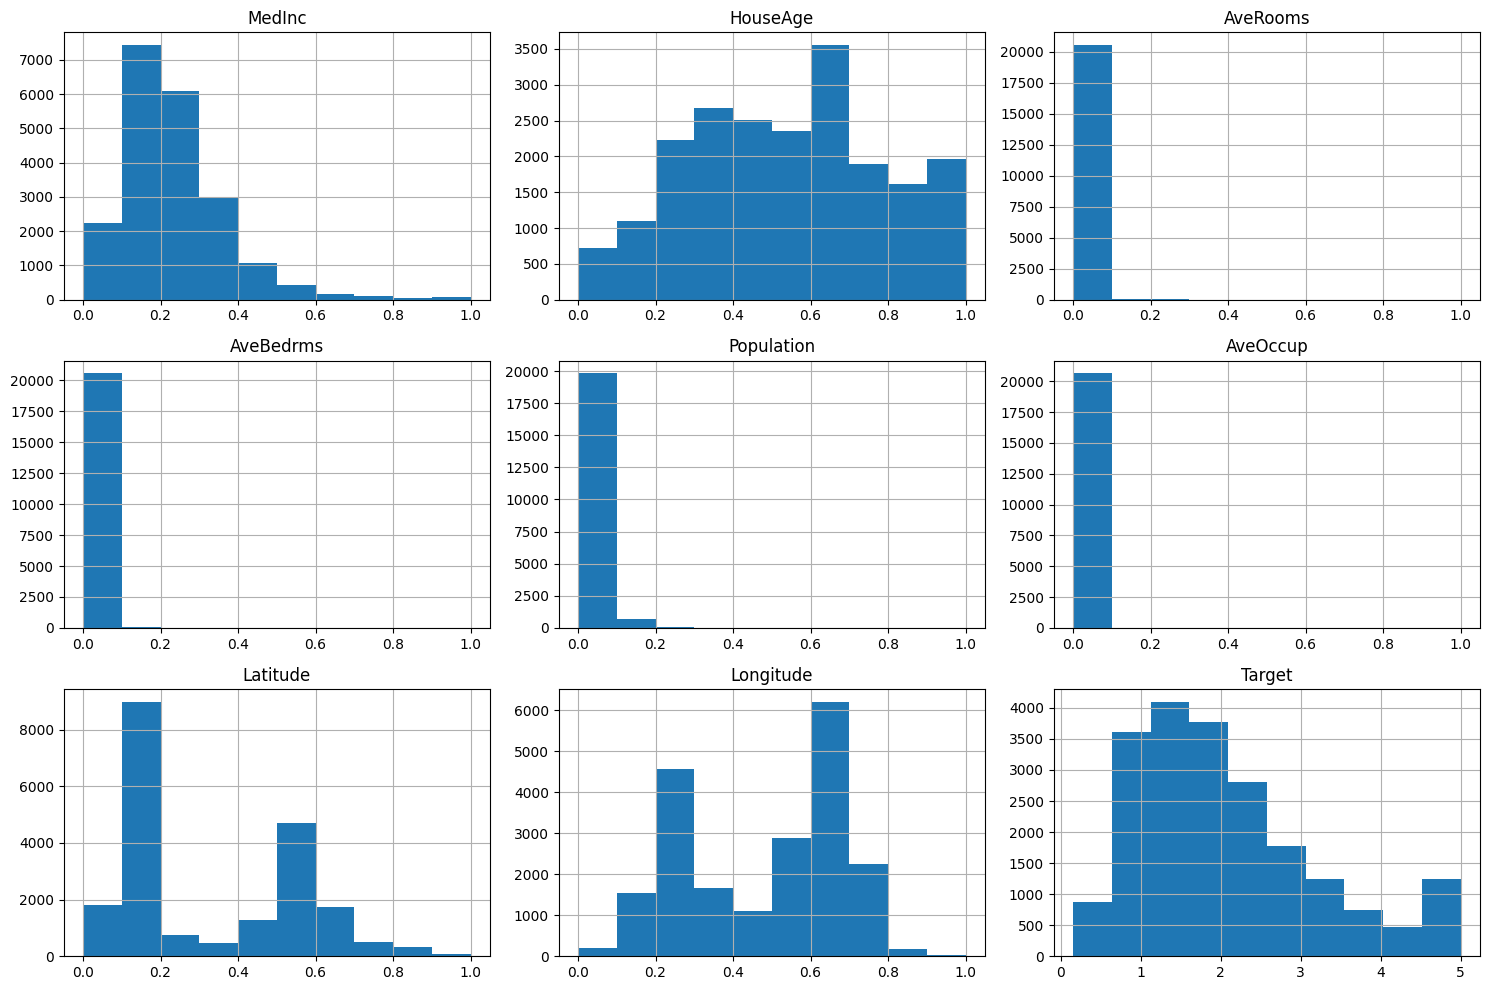

In [5]:
# Apply Min-Max normalization to all features
scaler = MinMaxScaler()
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

# Plot histograms for all features after normalization
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

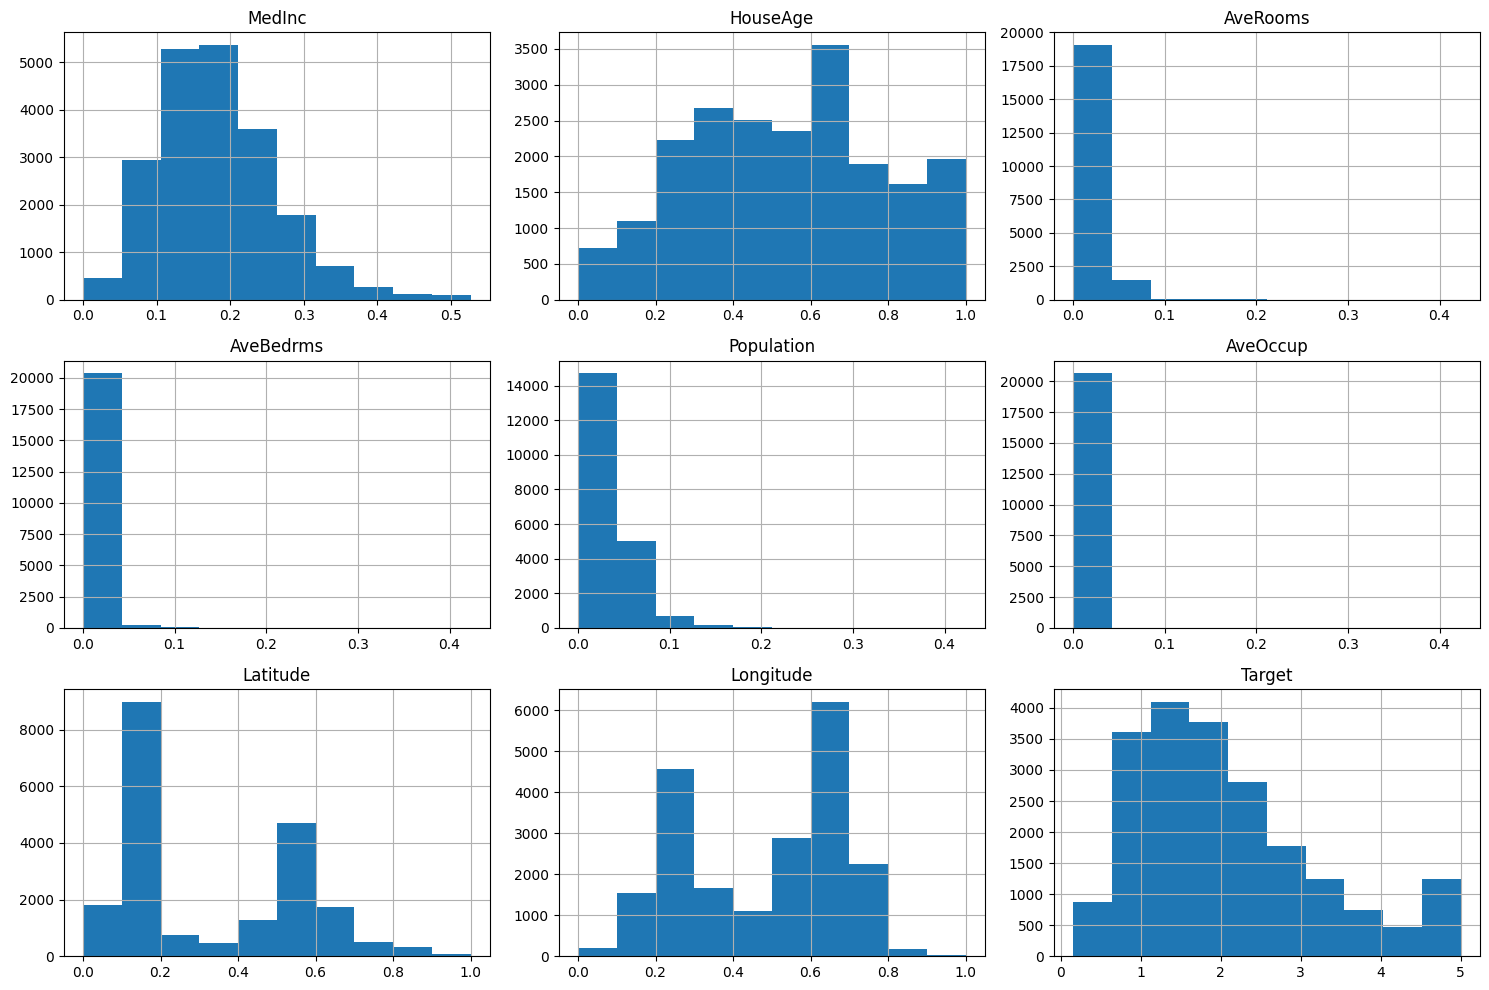

In [47]:

# Calculate skewness of features
skewness = df.drop(columns=['Target']).skew()

# Apply log transformation to features with skewness greater than 1
skewed_features = skewness[skewness > 1].index
df[skewed_features] = np.log1p(df[skewed_features])

# Plot histograms for all features after log transformation
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()
